In [1]:
# Necessary Libraries
# import pyforest
import psycopg2
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load enviroment variables from .env file
load_dotenv()
# Retreive database credentials from .env file
DB_name = os.getenv("DB_name")
DB_user = os.getenv("DB_user")
DB_passwd = os.getenv("DB_password")
DB_host = os.getenv("DB_host")
DB_port = os.getenv("DB_port")
print()
print(f"db_name={DB_name}, db_user={DB_user}, db_host={DB_host}, db_port={DB_port}")

# Function to fetch data and load it to a data frame
def fetch_data(table_name):
    """Connects to a postgreSQL database and fetch data then
    convert it into a dataframe"""
    # Establish connection
    conn = psycopg2.connect(
        dbname=DB_name,
        user=DB_user,
        password=DB_passwd,
        host=DB_host,
        port=DB_port
    )
    # Read the data into a DF
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql(query, conn)

    return df


db_name=postgres, db_user=luxds, db_host=172.178.131.221, db_port=5432


In [3]:
# Read the data from the database into a DataFrame(df)
table_name = 'ds.titanicdata'
df = fetch_data(table_name)
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S


In [4]:
# # Read data into a DataFrame
# df = pd.read_csv("D:\LuxDev\Week 7\Titanic-Dataset.csv")
# df.head()

In [5]:
# Check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        891 non-null    object 
 11  embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Check the unique values in the pclass column
print(df['pclass'].unique())
print(df['pclass'].value_counts())

[3 1 2]
pclass
3    491
1    216
2    184
Name: count, dtype: int64


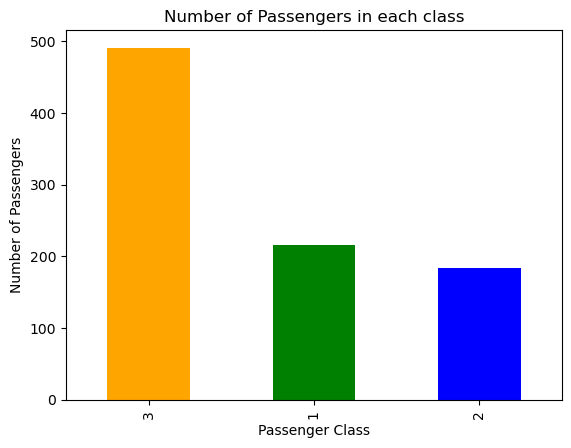

In [7]:
# Bar chart of the number of passengers in each class
df['pclass'].value_counts().plot(kind='bar', color=['orange', 'green', 'blue'])
plt.xlabel('Passenger Class')
plt.ylabel('Number of Passengers')
plt.title('Number of Passengers in each class')
plt.show()

In [8]:
# check the majority and minority class in the target column
df['survived'].value_counts()

survived
0    549
1    342
Name: count, dtype: int64

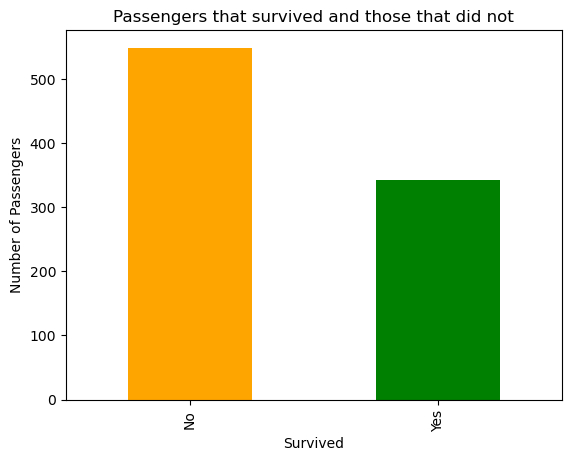

In [9]:
# Plot a bar chart of the passengers that survived and not in the target column
df['survived'].value_counts().plot(kind='bar', color=['orange', 'green'])
plt.xlabel('Survived')
plt.ylabel('Number of Passengers')
plt.title('Passengers that survived and those that did not')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

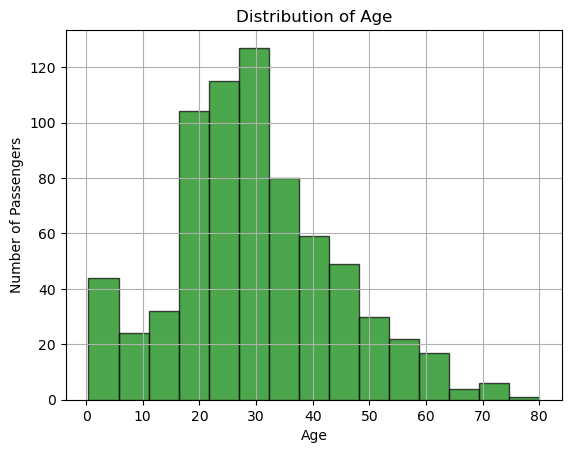

In [10]:
# Checking for distribution pattern in the age column
df['age'].hist(bins=15, color='green',  alpha=0.7, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.title('Distribution of Age')
plt.show()

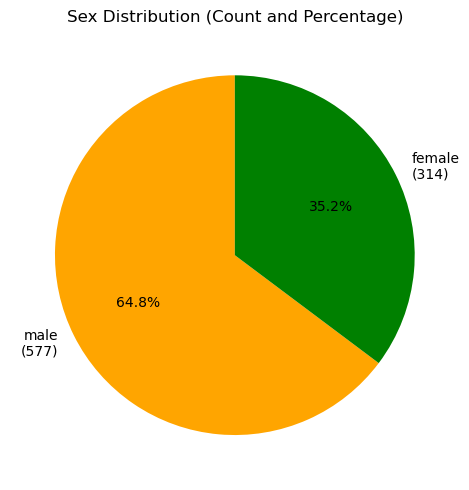

In [11]:
# Pie chart to show distribution of passengers onboard the ship by sex
sex_counts = df["sex"].value_counts()

plt.figure(figsize=(8, 5))
plt.pie(sex_counts,
        labels=[f'{k}\n({v})' for k, v in sex_counts.items()],
        autopct='%.1f%%',
        startangle=90,
        colors=['orange', 'green'])
plt.title('Sex Distribution (Count and Percentage)')
plt.tight_layout()
plt.show()

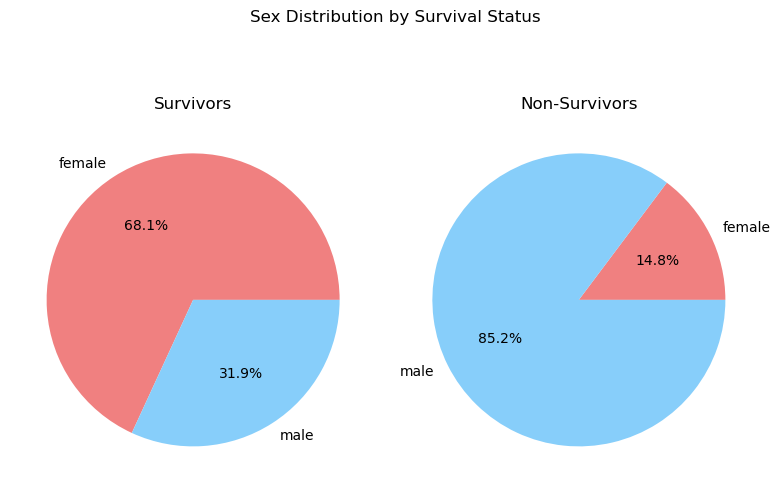

In [12]:
# Group by survival status and sex
survival_by_sex = df.groupby(['survived', 'sex']).size().unstack()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Survivors pie
ax1.pie(survival_by_sex.loc[1], labels=survival_by_sex.loc[1].index,
        autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
ax1.set_title('Survivors')

# Non-survivors pie
ax2.pie(survival_by_sex.loc[0], labels=survival_by_sex.loc[0].index,
        autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
ax2.set_title('Non-Survivors')

plt.suptitle('Sex Distribution by Survival Status', y=1.05)
plt.tight_layout()
plt.show()

In [13]:
# Create a wrangle function to clean the titanic data
def wrangle_data(df):
    """Cleans the Titanic dataset by handling missing values,
    encoding categorical variables, and dropping reduntant columns.

    Parameters:
    df (pd.DataFrame): Raw Titanic dataset

    Returns:
    pd.DataFrame: Cleaned dataframe ready for analysis
    """
    # Check for null values in the dataset and fill them with the mean or mode
    df['embarked'] = df['embarked'].replace(" ", np.nan)
    df['cabin'] = df['cabin'].replace('', np.nan)

    # Fill missing age values column with the median(not affected by outliers)& mode
    df['age'].fillna(df['age'].median(), inplace=True)
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

    # Initializing the label encoder, Encoding categorical variables
    le = LabelEncoder()
    df['embarked_transformed'] = le.fit_transform(df['embarked'])

    # One-hot encoding on the embarked & sex column- assign back to dataframe
    embarked_dummies = pd.get_dummies(
        df['embarked'], prefix='embarked', drop_first=True, dtype=int
    )
    sex_dummies = pd.get_dummies(
        df['sex'], prefix='sex', drop_first=True, dtype=int
    )
    df = pd.concat([df, embarked_dummies, sex_dummies], axis=1)

    # Drop columns that are not neccessary for the analysis
    df.drop(
        columns=['name', 'ticket', 'embarked_transformed',
                 'cabin', 'passengerid', 'embarked', 'sex'],
        inplace=True
    )

    return df

In [14]:
# Read refined data into a dataframe df_clean
df_clean = wrangle_data(df)
df_clean.head()

,survived,pclass,age,sibsp,parch,fare,embarked_Q,embarked_S,sex_male
0,0,3,22.0,1,0,7.2500,0,1,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,1,0
3,1,1,35.0,1,0,53.1000,0,1,0
4,0,3,35.0,0,0,8.0500,0,1,1


In [15]:
# Check the clean DataFrame(df_clean)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   age         891 non-null    float64
 3   sibsp       891 non-null    int64  
 4   parch       891 non-null    int64  
 5   fare        891 non-null    float64
 6   embarked_Q  891 non-null    int32  
 7   embarked_S  891 non-null    int32  
 8   sex_male    891 non-null    int32  
dtypes: float64(2), int32(3), int64(4)
memory usage: 52.3 KB


In [16]:
# Creating a feature matrix(X) and target variable(y)
y = df_clean['survived']
X = df_clean.drop(columns=['survived'])

In [17]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Check the shape of the train and test sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (712, 8), y_train shape: (712,)
X_test shape: (179, 8), y_test shape: (179,)


#### Due to the class imbalance we are to apply SMOTE
- SMOTE stands for Synthetic Minority Over-sampling Technique adding synthetic data to the minority class
- This is done after spliting the data and is applied to train data only
- The right procedure is to apply SMOTE then feature scale

In [19]:
# Applying SMOTE to the training data set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'Original dataset shape: {Counter(y_train)}')
print()
print(f'New dataset shape: {Counter(y_train_smote)}')

Original dataset shape: Counter({0: 441, 1: 271})

New dataset shape: Counter({0: 441, 1: 441})


In [20]:
# Check y_train_smote to confirm class balance
y_train_smote.value_counts()

survived
0    441
1    441
Name: count, dtype: int64

In [21]:
# Feature scaling- in our case I opt for Standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

#### Build Model
- Use Logistic regression
- You can create a pipeline to include OHE transformer and Logisticregression predictor also include simple imputer eg. mean, mode or median to fill in missing values(not necessary in our case)

In [23]:
# Building a model using LogisticRegression
model_lr = LogisticRegression(random_state=42)

# Fit the model to the training data
model_lr.fit(X_train_scaled, y_train_smote)

LogisticRegression(random_state=42)

#### Evaluate the model
- Two ways; training set and testing set
- test_acc= model.score(X_test, y_test)
- train_acc= model.score(X_train, y_train)
- print out: classification report(y_test, y_pred)
- print out: confusion_matrix(y_test, y_pred)

Train Accuracy: 0.8084
Test Accuracy: 0.7989
************************************************************
              precision    recall  f1-score   support

Not Survived       0.83      0.84      0.83       108
    Survived       0.75      0.73      0.74        71

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

************************************************************
Confusion Matrix:
[[91 17]
 [19 52]]
************************************************************


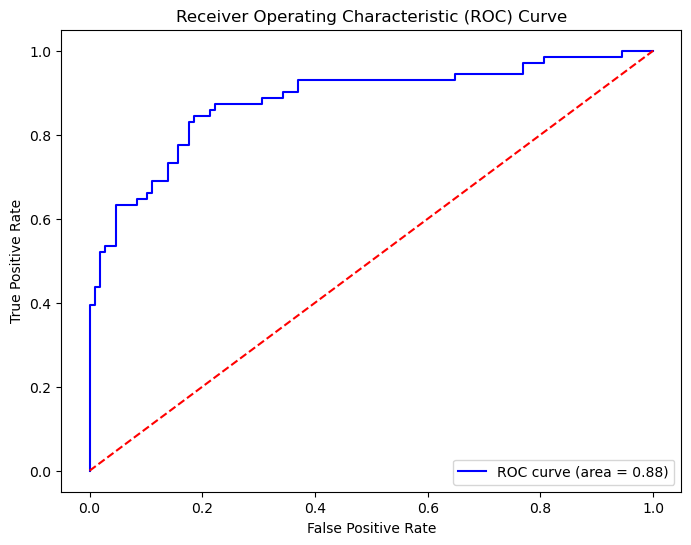

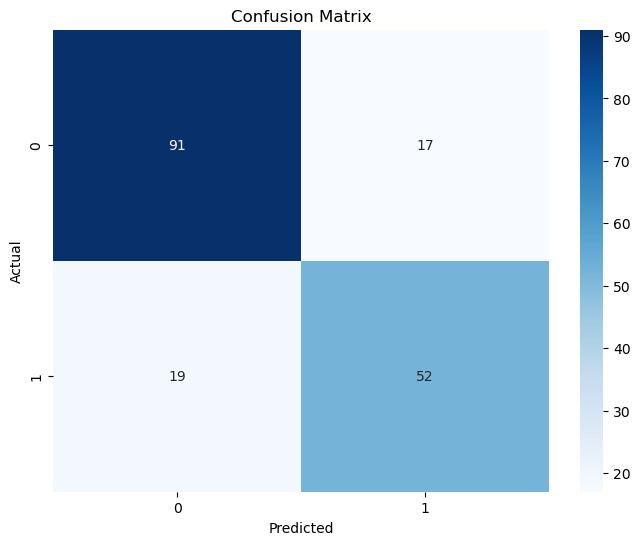

In [48]:
# Check for accuracy test and training data
train_accuracy = model_lr.score(X_train_scaled, y_train_smote)
test_accuracy = model_lr.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print('*'*60)

# check for classification report
y_pred_lr = model_lr.predict(X_test_scaled)
print(classification_report(
    y_test, y_pred_lr, target_names=['Not Survived', 'Survived'])
)
print('*'*60)

# Check for confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(cm_lr)
print('*'*60)

# Plot the ROC curve
y_pred_prob_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()